# PyEnGNet 1.0

En el presente documento pasaremos a mostrar paso por paso el funcionamiento del algoritmo EnGNet, para extraer redes de coexpresión a partir de datos de expresión genética tras ser sometidos a diversas metodologías.

In [1]:
import pandas as pd
import scipy.stats as scp
import numpy as np
from tqdm import tqdm
from sklearn.metrics.cluster import normalized_mutual_info_score
import networkx as nx

# Paso 1. Preparación de los datos para el algoritmo

Debemos definir la matriz de datos genéticos que se va a utilizar así como los umbrales que deben superar las medidas de correlación utilizadas por el algoritmo.

Suponiendo que partimos de este dataset

In [2]:
df = pd.read_csv("Data/113_exp_mat_cond_1.csv")
df = pd.DataFrame(df)
df

,Unnamed: 0,sample_3,sample_4,sample_5,sample_6,sample_9,sample_10,sample_11,sample_14,sample_15,...,sample_478,sample_482,sample_483,sample_485,sample_488,sample_493,sample_496,sample_497,sample_499,sample_500
0,ADR1,0.393726,0.139099,0.052912,0.079489,0.110079,0.076913,0.170031,0.076548,0.378425,...,0.135870,0.555923,0.053774,0.063177,0.120053,0.511716,0.171683,0.181483,0.186592,0.166621
1,FLO8,0.368257,0.226366,0.192921,0.304331,0.347783,0.460730,0.247321,0.488002,0.395741,...,0.368265,0.436692,0.331386,0.396856,0.187229,0.297722,0.384049,0.422091,0.349731,0.260438
2,GIS1,0.500661,0.267286,0.480420,0.449263,0.462302,0.332204,0.347251,0.346586,0.356450,...,0.452821,0.340253,0.482209,0.524972,0.486942,0.474888,0.435856,0.357013,0.610022,0.443499
3,IME4,0.418802,0.382483,0.333717,0.295416,0.313251,0.385264,0.350356,0.435079,0.418417,...,0.350447,0.329192,0.426531,0.389524,0.412562,0.483822,0.332376,0.317330,0.387120,0.373825
4,KAR4,0.528209,0.494533,0.466775,0.390307,0.547182,0.436885,0.585211,0.542756,0.565251,...,0.413356,0.582158,0.484834,0.523137,0.522180,0.286004,0.642618,0.526924,0.584369,0.533382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,ENT1,0.518182,0.575945,0.514139,0.538879,0.463914,0.420827,0.638548,0.450177,0.619931,...,0.545532,0.538625,0.435721,0.473603,0.701581,0.552184,0.544960,0.544448,0.543322,0.565474
109,KTR1,0.679404,0.622695,0.619771,0.718633,0.454273,0.554298,0.823445,0.462051,0.778620,...,0.637161,0.611109,0.622095,0.464864,0.763002,0.690760,0.697808,0.589683,0.568464,0.537067
110,KTR2,0.716606,0.762449,0.675982,0.752573,0.653249,0.656137,0.803875,0.610495,0.758321,...,0.782004,0.693562,0.580309,0.642324,0.659733,0.711134,0.755975,0.877445,0.751245,0.662435
111,SUT1,0.659796,0.546139,0.594530,0.635661,0.498229,0.605627,0.757235,0.567830,0.641744,...,0.606450,0.596641,0.561738,0.496406,0.738552,0.610183,0.640114,0.689054,0.546962,0.618393


manipulamos el dataset para obtener únicamente la matriz de datos

In [3]:
df = df.drop(df.columns[[0,2]], axis=1)
data = df.to_numpy()
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.393726,0.052912,0.079489,0.110079,0.076913,0.170031,0.076548,0.378425,0.069374,-0.024883,...,0.135870,0.555923,0.053774,0.063177,0.120053,0.511716,0.171683,0.181483,0.186592,0.166621
1,0.368257,0.192921,0.304331,0.347783,0.460730,0.247321,0.488002,0.395741,0.336612,0.395995,...,0.368265,0.436692,0.331386,0.396856,0.187229,0.297722,0.384049,0.422091,0.349731,0.260438
2,0.500661,0.480420,0.449263,0.462302,0.332204,0.347251,0.346586,0.356450,0.509264,0.486996,...,0.452821,0.340253,0.482209,0.524972,0.486942,0.474888,0.435856,0.357013,0.610022,0.443499
3,0.418802,0.333717,0.295416,0.313251,0.385264,0.350356,0.435079,0.418417,0.390439,0.357992,...,0.350447,0.329192,0.426531,0.389524,0.412562,0.483822,0.332376,0.317330,0.387120,0.373825
4,0.528209,0.466775,0.390307,0.547182,0.436885,0.585211,0.542756,0.565251,0.436395,0.460720,...,0.413356,0.582158,0.484834,0.523137,0.522180,0.286004,0.642618,0.526924,0.584369,0.533382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.518182,0.514139,0.538879,0.463914,0.420827,0.638548,0.450177,0.619931,0.414552,0.530368,...,0.545532,0.538625,0.435721,0.473603,0.701581,0.552184,0.544960,0.544448,0.543322,0.565474
109,0.679404,0.619771,0.718633,0.454273,0.554298,0.823445,0.462051,0.778620,0.607679,0.716958,...,0.637161,0.611109,0.622095,0.464864,0.763002,0.690760,0.697808,0.589683,0.568464,0.537067
110,0.716606,0.675982,0.752573,0.653249,0.656137,0.803875,0.610495,0.758321,0.646875,0.592495,...,0.782004,0.693562,0.580309,0.642324,0.659733,0.711134,0.755975,0.877445,0.751245,0.662435
111,0.659796,0.594530,0.635661,0.498229,0.605627,0.757235,0.567830,0.641744,0.538927,0.681520,...,0.606450,0.596641,0.561738,0.496406,0.738552,0.610183,0.640114,0.689054,0.546962,0.618393


Y definimos las variables del algoritmo

In [4]:
row_size = len(data)
column_size = len(data[0])

spearman_threshold = 0.7
kendall_threshold  = 0.7
nmi_threshold = 0.6
pearson_threshold = 0.7

# Paso 2. Definición de las funciones utilizadas por el algoritmo

Funciones de tests de correlación unitarios

In [5]:
def single_nmi(arr1, arr2, precission=1):
    ans = 0
    rnd = lambda x: round(x, precission)
    v1 = np.array(list(map(rnd, arr1)))
    v2 = np.array(list(map(rnd, arr2)))
    corr = normalized_mutual_info_score(v1, v2)
    if corr >= nmi_threshold:
        ans = 1
    return ans, corr
    

def single_spearman(arr1, arr2):
    ans = 0
    corr, pv = scp.spearmanr(arr1, arr2)
    corr = abs(corr)
    if corr >= spearman_threshold:
        ans = 1
    return ans, corr


def single_pearson(arr1, arr2):
    ans = 0
    corr, pv = scp.pearsonr(arr1, arr2)
    corr = abs(corr)
    if corr >= pearson_threshold:
        ans = 1
    return ans, corr


def single_kendall(arr1, arr2):
    ans = 0
    corr, pv = scp.kendalltau(arr1, arr2)
    corr = abs(corr)
    if corr >= kendall_threshold:
        ans = 1
    return ans, corr

Función para validar la correlación entre dos vectores de expresión genética

In [6]:
def validate_corr(i, j, accepted_values, data):
    major_voting = 0

    # Las dos filas que vamos a utilizar
    v = data[i]
    w = data[j]

    # Agregamos las respuestas de los tests a una lista que servirá para el calculo de los pesos
    tests = [single_pearson(v, w), single_kendall(v, w), single_spearman(v, w)]

    for test in tests:
        major_voting += test[0]

    if major_voting >= len(tests)/2:
        accepted_values.append((i, j, {'weight': calculate_weight(tests)}))

Función para calcular el peso de una correlación exitosa en la validación

In [7]:
def calculate_weight(tests):
    weight = []

    for test in tests:
        if bool(test[0]):
            weight.append(test[1])
            
    return np.mean(weight)

Funcionamiento del bucle de EnGNet

In [8]:
def engnet_1_0(row_size, data):
    engnet_accepted_values = []

    for i in tqdm(range(row_size)):
        for j in range(i + 1, row_size):
            validate_corr(i, j, engnet_accepted_values, data)
            
    return engnet_accepted_values

# Paso 3. Ejecutar, obtener el grafo principal y obtener el arbol de recorrido máximo

Con lo anterior definido obtenemos las aristas de proporcionadas por EnGNet

In [9]:
%%time
oedges = engnet_1_0(row_size, data)
G = nx.Graph()
G.add_edges_from(oedges)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:04<00:00, 25.97it/s]

CPU times: user 4.36 s, sys: 13.7 ms, total: 4.37 s
Wall time: 4.36 s


In [21]:
options = {
    'node_color': 'black',
    'font_color': 'white',
    'with_labels': True
}

newhead = ["GenA", "GenB", "Weight"]
pd.DataFrame(oedges, columns=newhead)


,GenA,GenB,Weight
0,8,55,{'weight': 0.7089923579941719}
1,43,52,{'weight': 0.7155115996731671}
2,43,55,{'weight': 0.7462321210562424}
3,47,61,{'weight': 0.7041228657045737}
4,47,66,{'weight': 0.7199583800134501}
5,52,66,{'weight': 0.7473299128183515}
6,52,74,{'weight': 0.7180753552255581}
7,55,57,{'weight': 0.7228738030320297}
8,55,74,{'weight': 0.7277715940754805}
9,57,60,{'weight': 0.7175741808144404}


## Red original

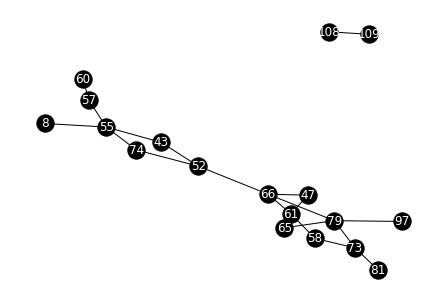

In [22]:
nx.draw(G, **options)

## Bosque de recubrimiento máximo de la red

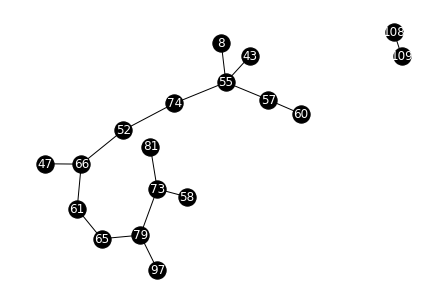

In [23]:
G2 = nx.maximum_spanning_tree(G, weight='weight', algorithm="kruskal")
nx.draw(G2, **options)
fedges = nx.to_edgelist(G2)

## Adición de edges eliminados a los hubs
Estos son las aristas que han sido quitadas de la red principal. 

El threshold que deben superar las aristas para añadirlas a la red principal es elegido por el usuario

In [27]:
edges_out = [edge for edge in oedges if edge not in fedges]

### Identificación de hubs en la red

Se denominan hubs aquellos nodos que poseen más conexiones que el resto.

Para poder afinar más esta medida, descartaremos aquellos nodos cuyo grado es inferior a dos. puesto que sólo son nodos puente o extremos en la red.

De los nodos restantes que cumplen que su grado es superior a dos, calculamos la media de la graduación de los nodos y aquellos que se sitúen por encima de la media, serán hubs

In [28]:
mean_degree = round(np.mean([G2.degree(node) for node in G2.nodes if G2.degree(node) > 2]))

print("Grado medio de los nodos con más de dos conexiones:", mean_degree)
print("----------------------------------------------------------------")
print("Nodos que superan la media y su grado\n")

hubs = []
for node in G2.nodes:
    if G2.degree(node) >= mean_degree:
        print(node, "\t---->\t", G2.degree(node))
        hubs.append(node)
print("----------------------------------------------------------------")
print("Aristas que fueron eliminadas del grafo tras el prunning process")
pd.DataFrame(edges_out)

Grado medio de los nodos con más de dos conexiones: 3
----------------------------------------------------------------
Nodos que superan la media y su grado

55 	---->	 4
66 	---->	 3
73 	---->	 3
79 	---->	 3
----------------------------------------------------------------
Aristas que fueron eliminadas del grafo tras el prunning process


,0,1,2
0,43,52,{'weight': 0.7155115996731671}
1,47,61,{'weight': 0.7041228657045737}
2,58,61,{'weight': 0.7014477061458867}
3,66,79,{'weight': 0.7100447929147558}


### Añadir edges eliminados a los hubs de la red

Una vez se han obtenido los hubs de la red, usamos los edges eliminados para volver a añadirlos a esos hubs, en caso de que superen un cierto umbral determinado por el usuario.

Introduzca umbral: 0.7


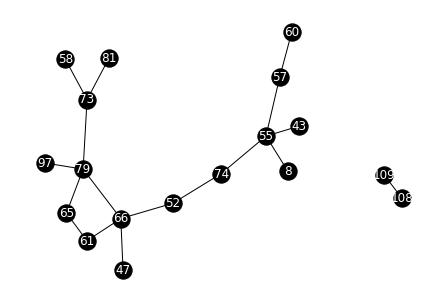

In [32]:
readded = []
threshold = float(input("Introduzca umbral:"))
for node in hubs:
    for e in edges_out:
        if node in e and e not in readded and e[2]['weight'] >= threshold:
            readded.append(e)
            
G3 = nx.Graph()
G3.add_edges_from(nx.to_edgelist(G2))
G3.add_edges_from(readded)
nx.draw(G3, **options)

# Resumen

Para poner PyEnGNet al servicio del usuario los métodos anteriormente descritos son encapsulados en la clase PyEnGNet de forma que podemos obtener el grafo final y la lista de aristas que lo componen.
Además se ha aplicado un modelo de paralelización del método principal para una ejecución más veloz del mismo

In [46]:
%%time
from pyEnGNet import *

# Cambie el valor de los datos de entrada del algoritmo como estime necesario

spearman_threshold = 0.7
kendall_threshold  = 0.7
nmi_threshold      = 0.6
pearson_threshold  = 0.7

readded_th         = 0.7

number_of_cores    = 6

p = PyEnGNet(data, spearman_th=spearman_threshold, pearson_th=pearson_threshold, kendall_th=kendall_threshold, readded_th=readded_th, cores=number_of_cores)

Gp, edges = p.engnet_1_0()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 12.04it/s]


[(79, 66, {'weight': 0.7100447929147558})]
CPU times: user 34.4 ms, sys: 59.3 ms, total: 93.6 ms
Wall time: 1.55 s


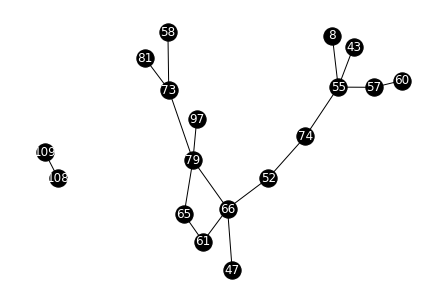

In [39]:
nx.draw(Gp, **options)

Aunque ahora mismo PyEnGNet no es un algoritmo especialmente veloz, se pretende aplicar una estrategia de paralelismo para acelerar la eficacia del mismo